In [301]:
import torch
import os
import numpy as np
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def checkpoint_epoch(folder, epoch=19):
    files = os.listdir(folder)
    f = [f for f in files if "batches_{}_.pth".format(epoch) in f]
    if len(f) > 0:
        return f[0]
    return -1

def add_metadata(fname, d):
    match = re.search('width_mult_\d+(\.\d+)?', fname)
    if match:
        width_mult = match.group(0)[len("width_mult_"):]
        d["width_mult"] = float(width_mult)
    match = re.search('-lr_\d+.\d+', fname)
    if match:
        value = match.group(0)[len("-lr_"):]
        d["lr"] = float(value)
    match = re.search('-depth_mult_\d+', fname)
    if match:
        value = match.group(0)[len("-depth_mult_"):]
        d["depth_mult"] = int(value)
    match = re.search('-parametr_mup_depth', fname)
    if match:
        d["mup_depth"] = True
    else:
        d["mup_depth"] = False
        
    match = re.search('skip_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("skip_scaling_"):]
        d["skip_scaling"] = float(value)
    else:
        d["skip_scaling"] = 1.0
    
    match = re.search('res_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("res_scaling_"):]
        d["res_scaling"] = float(value)
    else:
        d["res_scaling"] = 1.0
    
    match = re.search('epoch_\d+', fname)
    if match:
        width_mult = match.group(0)[len("epoch_"):]
        d["epochs"] = int(width_mult)
        
    match = re.search('seed_\d+', fname)
    if match:
        s = match.group(0)[len("seed_"):]
        d["seed"] = int(s)
    else:
        d["seed"] = None
    
    match = re.search('beta_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("beta_"):]
        d["beta"] = float(value)
    else:
        d["beta"] = 1.0
    
    match = re.search('gamma_zero_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("gamma_zero_"):]
        d["gamma_zero"] = float(value)
    else:
        d["gamma_zero"] = 1.0
        
    match = re.search('-norm_ln', fname)
    if match:
        d["norm"] = "ln"
    elif re.search('-norm_bn', fname):
        d["norm"] = "ln"
    elif re.search('-norm_None', fname):
        d["norm"] = None
    else:
        d["norm"] = None
    
    match = re.search('k_layers_\d+', fname)
    if match:
        value = match.group(0)[len("k_layers_"):]
        d["k_layers"] = int(value)
    else:
        d["k_layers"] = None
        
    match = re.search('batch_size_\d+', fname)
    if match:
        value = match.group(0)[len("batch_size_"):]
        d["batch_size"] = int(value)
    else:
        d["batch_size"] = None
    return d


def get_data(folder_path, epoch=19):
    final_d = []
    for fp in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fp)
        d_file = checkpoint_epoch(fpath, epoch=epoch)
        if d_file != -1:
            fpath = os.path.join(fpath, checkpoint_epoch(fpath, epoch=epoch))
            d = torch.load(fpath)
            d = add_metadata(fp, d)
            d["name"] = fp
            final_d.append(d)
    return final_d


def normalization(arr):
    arr = np.asarray(arr)
    extreme_mean = (arr[0] + arr[-1])/2
    return arr / extreme_mean

def loss_curves(run_ds, train=True, acc=True, epoch=0):
    ds = []
    for _, d in enumerate(run_ds):
        for i in range(len(d["metrics"])):
            loss_d = pd.DataFrame()
            d_epoch = d["metrics"][i]
            try:
                if train:
                    loss_d["train_loss"] =  normalization(d_epoch["train_loss"])
                    if acc:
                        if "train_acc" in d_epoch.keys() and len(d_epoch['train_acc']) > 0:
                            loss_d["train_acc"] =  d_epoch["train_acc"]
                    if "trace" in d_epoch.keys() and len(d_epoch["trace"]) > 1:
                        loss_d["trace"] = d_epoch["trace"]
                    if "top_eig" in d_epoch.keys() and len(d_epoch["top_eig"]) > 1:
                        loss_d["top_eig"] = d_epoch["top_eig"]
                else:
                    loss_d["test_loss"] =  normalization(d_epoch["test_loss"])
                    loss_d["test_acc"] =  normalization(d_epoch["test_acc"])
                loss_d["lr"] = d["lr"]
                loss_d["width_mult"] = d["width_mult"]
                loss_d["depth_mult"] = d["depth_mult"]
                loss_d["step"] = loss_d.index
                loss_d["beta"] = d["beta"]
                loss_d["gamma_zero"] = d["gamma_zero"]
                loss_d["k_layers"] = d["k_layers"]
                loss_d["batch_size"] = d["batch_size"]
                loss_d["seed"] = d["seed"]
                loss_d["epoch"] = d["epoch"]
                ds.append(loss_d)
            except KeyError:
                continue
    return pd.concat(ds, axis=0)


def get_metrics_df(run_ds, metric):
    ds = []
    for d in run_ds:
        try:
            d[metric] = d['metrics'][metric][-1]
            d = {k: d[k] for k in (metric, 'lr', 'width_mult', 'depth_mult', 'mup_depth', 'norm', 'gamma_zero', 'beta', 'k_layers', 'batch_size', 'seed')}
            ds.append(d)
        except KeyError as e:
            print(e)
            continue
    return pd.DataFrame(ds)

In [307]:
folder_path = "/local/home/lnoci/nn_large_depth_width_landscape-1/mode_connectivity_mup_sqrt_depth_small"

tot_runs = []
epoch = 0

run_ds = get_data(folder_path, epoch=epoch)

print(len(run_ds[0]))
print(len(run_ds[0]["metrics"]))

lc = loss_curves(run_ds, epoch=epoch)
lc["alpha"] = lc["step"] / 10
tot_runs.append(lc)
df_runs = pd.concat(tot_runs)
df_runs


16
1


,train_loss,train_acc,lr,width_mult,depth_mult,step,beta,gamma_zero,k_layers,batch_size,seed,epoch,alpha
0,0.996803,39.186,0.1,32.0,0,0,1.0,1.0,1,64,1111,0,0.0
1,0.985500,39.960,0.1,32.0,0,1,1.0,1.0,1,64,1111,0,0.1
2,0.976566,40.692,0.1,32.0,0,2,1.0,1.0,1,64,1111,0,0.2
3,0.969996,41.132,0.1,32.0,0,3,1.0,1.0,1,64,1111,0,0.3
4,0.966120,41.366,0.1,32.0,0,4,1.0,1.0,1,64,1111,0,0.4
5,0.965385,41.406,0.1,32.0,0,5,1.0,1.0,1,64,1111,0,0.5
6,0.967022,41.214,0.1,32.0,0,6,1.0,1.0,1,64,1111,0,0.6
7,0.971855,40.676,0.1,32.0,0,7,1.0,1.0,1,64,1111,0,0.7
8,0.979405,39.880,0.1,32.0,0,8,1.0,1.0,1,64,1111,0,0.8
9,0.989692,39.032,0.1,32.0,0,9,1.0,1.0,1,64,1111,0,0.9


/tmp/ipykernel_1767651/2371392709.py:10: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")


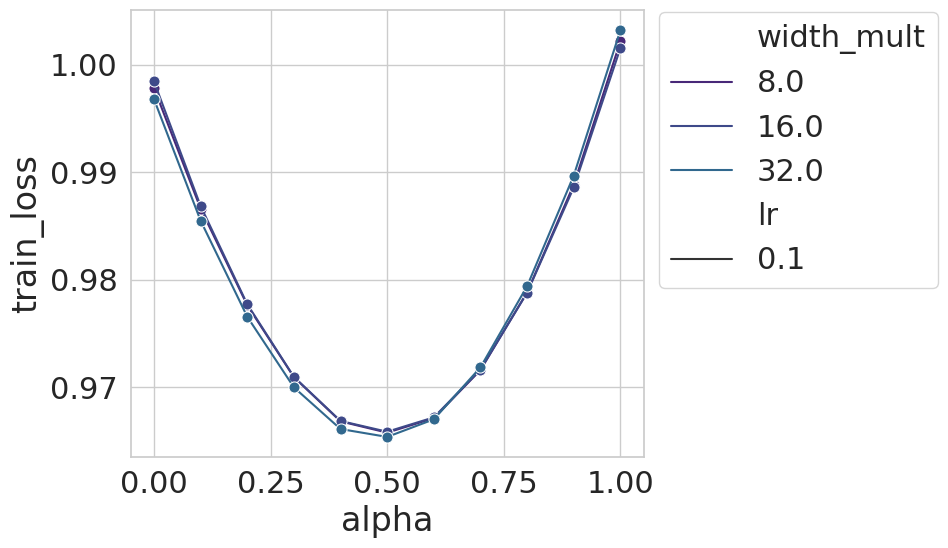

In [308]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
metric="train_loss"

df = df_runs[df_runs["depth_mult"] == 0]
df = df[df["epoch"] == 10]

#print(df)

ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

# ax.set_yticks([1, 2, 4, 8])
# ax.set_yticklabels([r"$10^0$", r"$2\times 10^0$", r"$4\times 10^0$", r"$8\times 10^0$"])
plt.tight_layout()

/tmp/ipykernel_1767651/2527211825.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


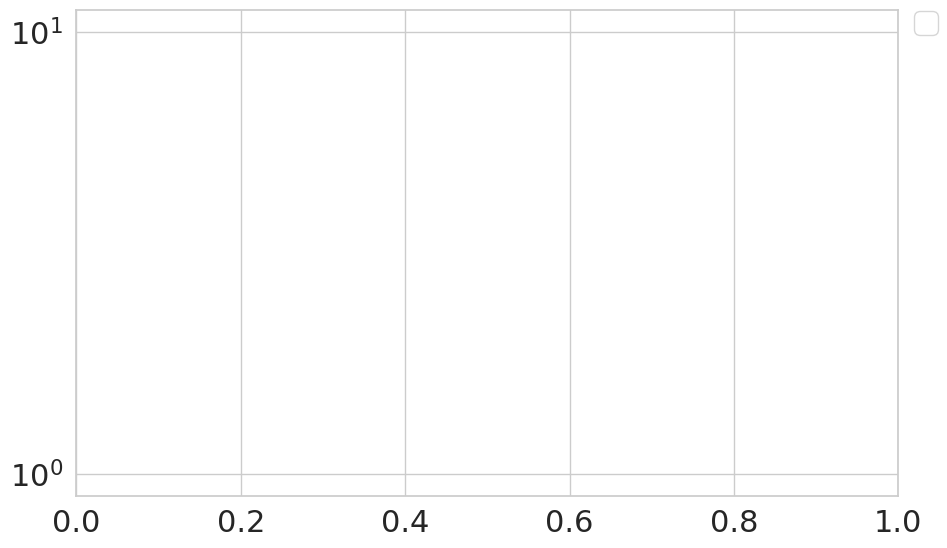

In [298]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
metric="train_loss"

df = df_runs[df_runs["depth_mult"] == 0]
df = df[df["epoch"] == epoch-2]

#print(df)

ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

plt.yscale('log')
# ax.set_yticks([1, 2, 4, 8])
# ax.set_yticklabels([r"$10^0$", r"$2\times 10^0$", r"$4\times 10^0$", r"$8\times 10^0$"])
plt.tight_layout()

/tmp/ipykernel_1767651/1852626224.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


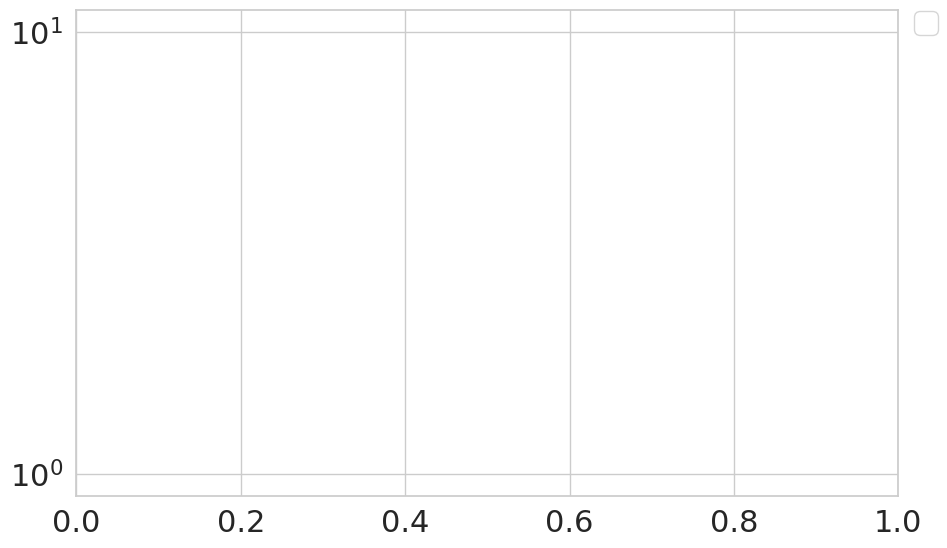

In [261]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
metric="train_loss"

df = df_runs[df_runs["depth_mult"] == 0]
df = df[df["epoch"] == 18]
df = df[df["width_mult"] == 32]

#print(df)

ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

plt.yscale('log')
# ax.set_yticks([1, 2, 4, 8])
# ax.set_yticklabels([r"$10^0$", r"$2\times 10^0$", r"$4\times 10^0$", r"$8\times 10^0$"])
plt.tight_layout()

/tmp/ipykernel_1767651/2750152461.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


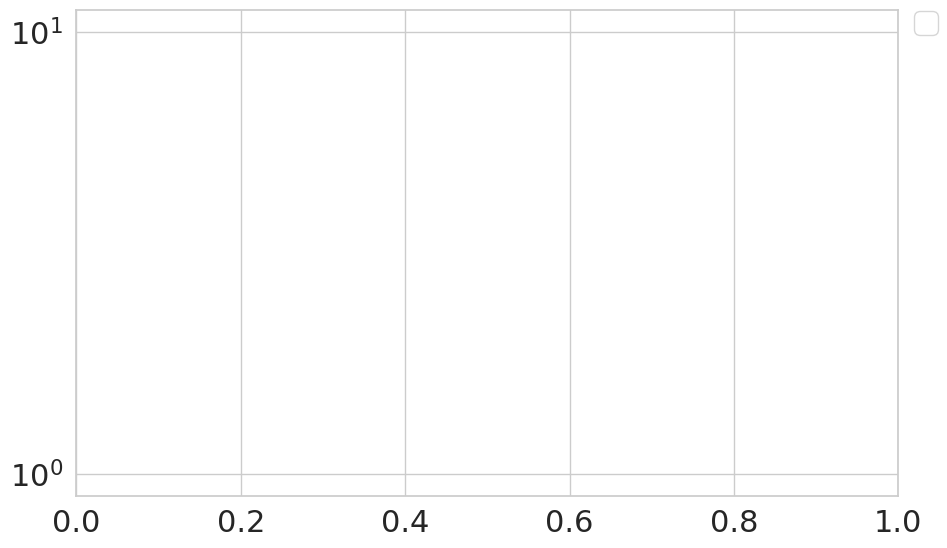

In [155]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
metric="train_loss"

df = df_runs[df_runs["depth_mult"] == 1]
df = df[df["epoch"] == 39]

#print(df)

ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

plt.yscale('log')
# ax.set_yticks([1, 2, 4, 8])
# ax.set_yticklabels([r"$10^0$", r"$2\times 10^0$", r"$4\times 10^0$", r"$8\times 10^0$"])
plt.tight_layout()

/tmp/ipykernel_1767651/3305028790.py:10: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")


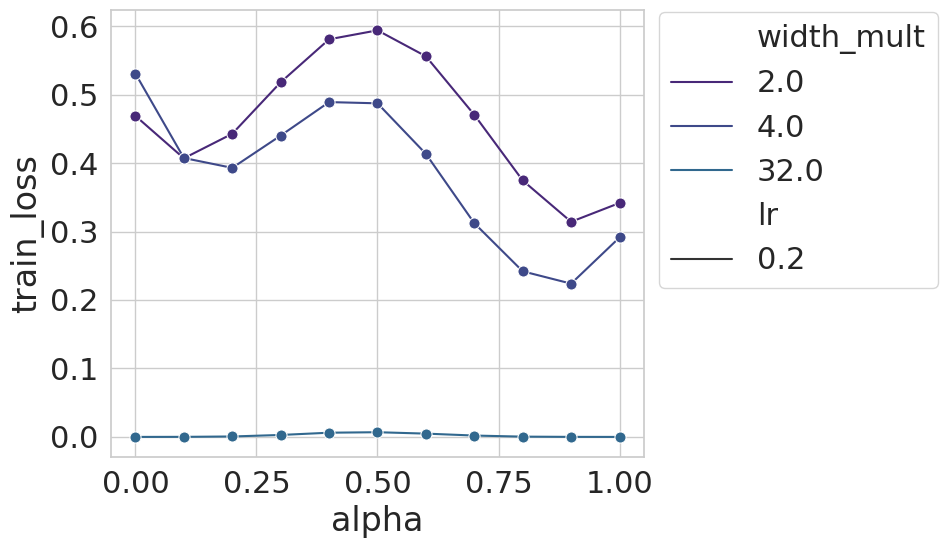

In [136]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
metric="train_loss"

df = df_runs[df_runs["depth_mult"] == 1]
df = df[df["epoch"] == 48]

#print(df)

ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

# ax.set_yticks([1, 2, 4, 8])
# ax.set_yticklabels([r"$10^0$", r"$2\times 10^0$", r"$4\times 10^0$", r"$8\times 10^0$"])
plt.tight_layout()

/tmp/ipykernel_1767651/50829504.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df, x='alpha', y=metric, hue="depth_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


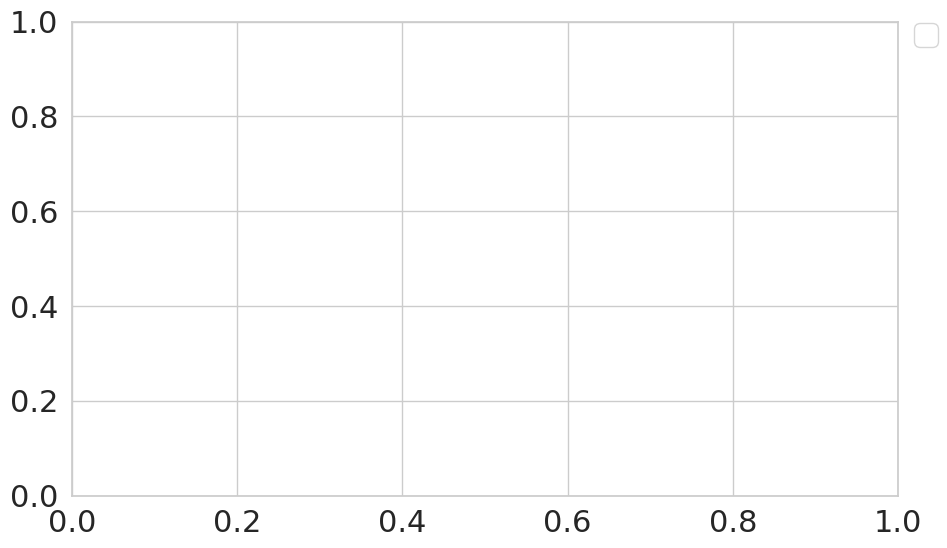

In [214]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
metric="train_loss"

df = df_runs[df_runs["width_mult"] == 4]
df = df[df["epoch"] == 39]
df = df[df["depth_mult"]>1]

#print(df)

ax = sns.lineplot(data=df, x='alpha', y=metric, hue="depth_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

# ax.set_yticks([1, 2, 4, 8])
# ax.set_yticklabels([r"$10^0$", r"$2\times 10^0$", r"$4\times 10^0$", r"$8\times 10^0$"])
plt.tight_layout()

In [271]:
folder_path = "/local/home/lnoci/nn_large_depth_width_landscape-1/mode_connectivity_mup_sqrt_depth_small"

tot_runs = []

epoch = 75
run_ds = get_data(folder_path, epoch=epoch)

print(len(run_ds[0]))
print(len(run_ds[0]["metrics"]))

lc = loss_curves(run_ds, epoch=epoch, train=False)
lc["alpha"] = lc["step"] / 10
tot_runs.append(lc)
df_runs = pd.concat(tot_runs)
df_runs


16
76


,test_loss,test_acc,lr,width_mult,depth_mult,step,beta,gamma_zero,k_layers,batch_size,seed,epoch,alpha
0,0.932723,1.074825,0.2,2.0,0,0,1.0,1.0,1,64,1111,0,0.0
1,0.931024,1.083180,0.2,2.0,0,1,1.0,1.0,1,64,1111,0,0.1
2,0.932697,1.086620,0.2,2.0,0,2,1.0,1.0,1,64,1111,0,0.2
3,0.937734,1.083671,0.2,2.0,0,3,1.0,1.0,1,64,1111,0,0.3
4,0.946192,1.081214,0.2,2.0,0,4,1.0,1.0,1,64,1111,0,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,0.744875,1.056260,0.2,4.0,0,6,1.0,1.0,1,64,1111,74,0.6
7,0.748748,1.063883,0.2,4.0,0,7,1.0,1.0,1,64,1111,74,0.7
8,0.771460,1.065043,0.2,4.0,0,8,1.0,1.0,1,64,1111,74,0.8
9,0.825917,1.062060,0.2,4.0,0,9,1.0,1.0,1,64,1111,74,0.9


/tmp/ipykernel_1767651/2836817849.py:8: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")


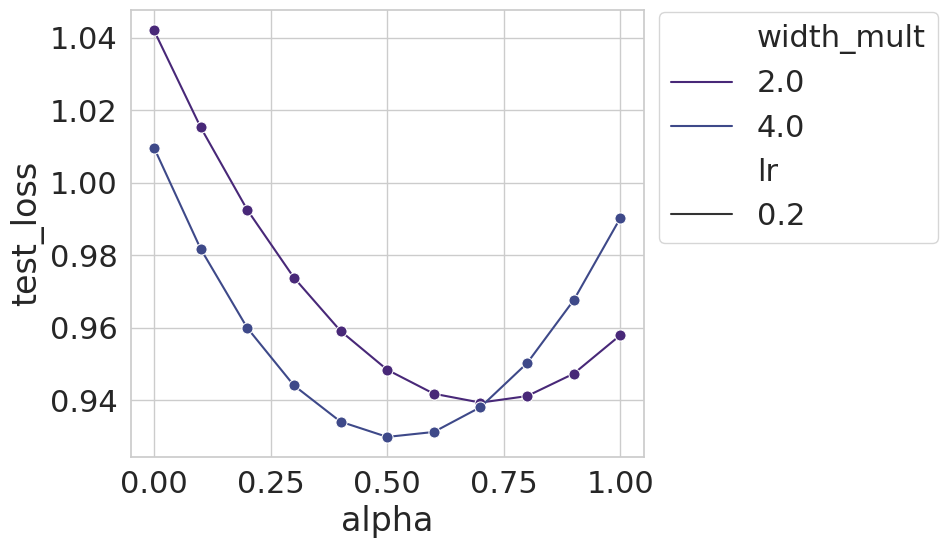

In [272]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
metric="test_loss"

df = df_runs[df_runs["epoch"] == 1]
df[df["depth_mult"] == 0]

ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

# ax.set_yticks([1, 2, 4, 8])
# ax.set_yticklabels([r"$10^0$", r"$2\times 10^0$", r"$4\times 10^0$", r"$8\times 10^0$"])
plt.tight_layout()

/tmp/ipykernel_1767651/3810864305.py:8: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")


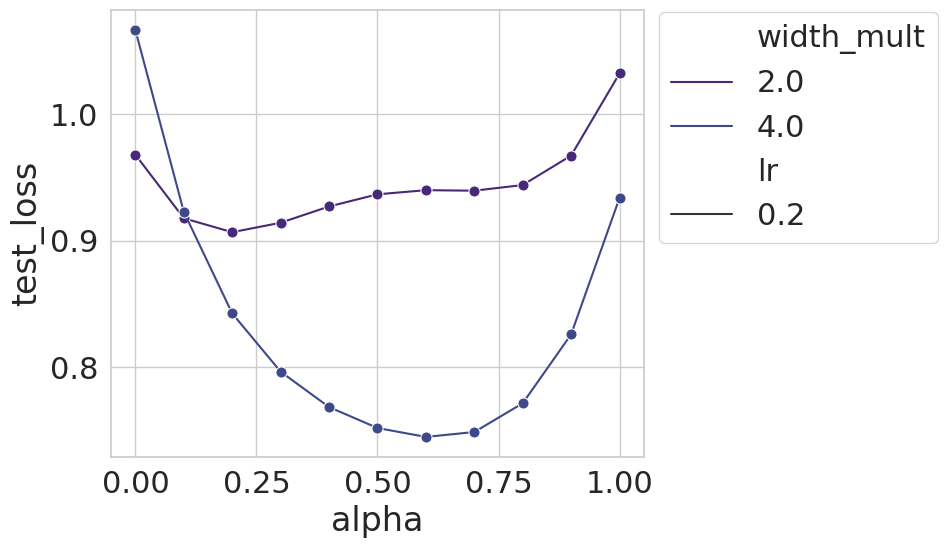

In [273]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
metric="test_loss"

df = df_runs[df_runs["epoch"] == epoch-1]
df[df["depth_mult"] == 0]

ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

# ax.set_yticks([1, 2, 4, 8])
# ax.set_yticklabels([r"$10^0$", r"$2\times 10^0$", r"$4\times 10^0$", r"$8\times 10^0$"])
plt.tight_layout()

/tmp/ipykernel_1767651/4032276762.py:8: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")


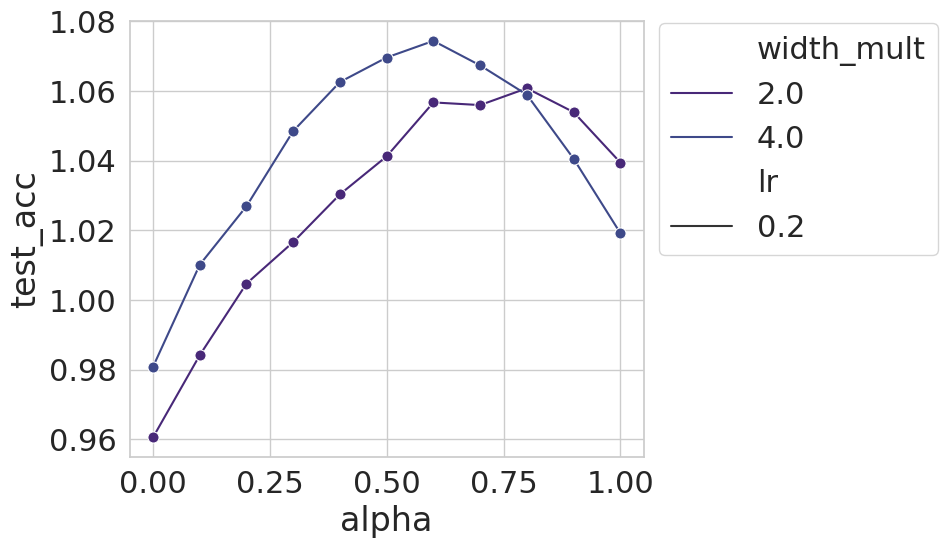

In [274]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
metric="test_acc"

df = df_runs[df_runs["epoch"] == 1]
df[df["depth_mult"] == 0]

ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

# ax.set_yticks([1, 2, 4, 8])
# ax.set_yticklabels([r"$10^0$", r"$2\times 10^0$", r"$4\times 10^0$", r"$8\times 10^0$"])
plt.tight_layout()

/tmp/ipykernel_1767651/174222976.py:8: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")


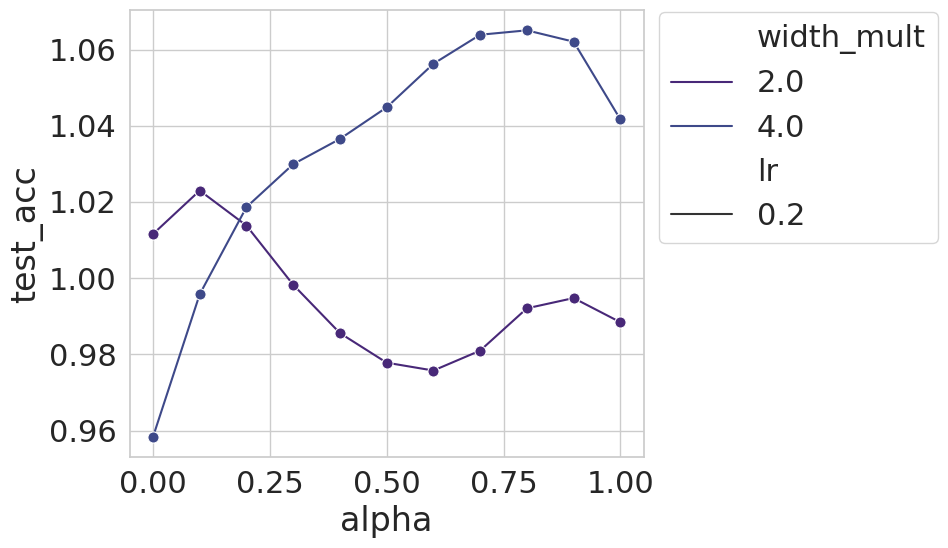

In [275]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
metric="test_acc"

df = df_runs[df_runs["epoch"] == epoch-1]
df[df["depth_mult"] == 0]

ax = sns.lineplot(data=df, x='alpha', y=metric, hue="width_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

# ax.set_yticks([1, 2, 4, 8])
# ax.set_yticklabels([r"$10^0$", r"$2\times 10^0$", r"$4\times 10^0$", r"$8\times 10^0$"])
plt.tight_layout()

/tmp/ipykernel_1767651/3692418982.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df, x='alpha', y=metric, hue="depth_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


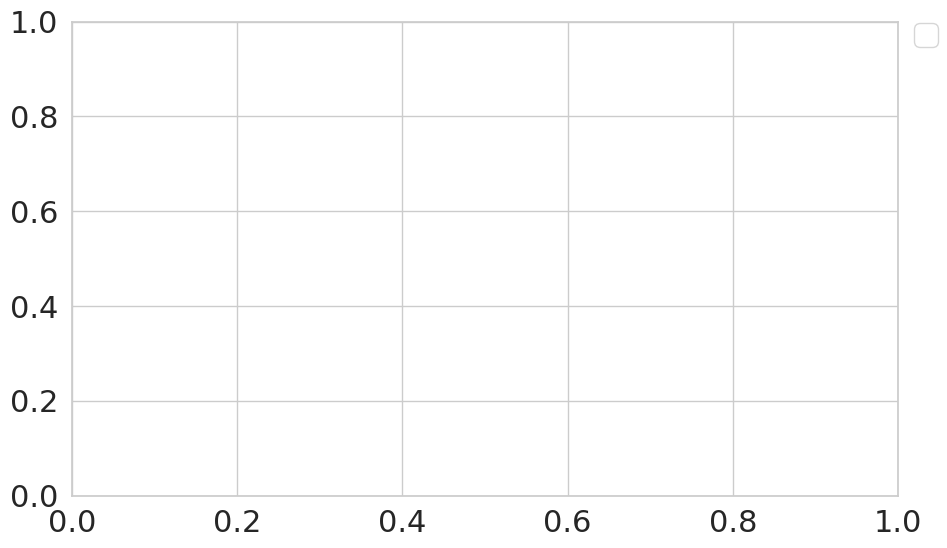

In [218]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
metric="test_loss"

df = df_runs[df_runs["width_mult"] == 4]
df = df[df["epoch"] == 48]
df = df[df["depth_mult"]>1]

#print(df)

ax = sns.lineplot(data=df, x='alpha', y=metric, hue="depth_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

# ax.set_yticks([1, 2, 4, 8])
# ax.set_yticklabels([r"$10^0$", r"$2\times 10^0$", r"$4\times 10^0$", r"$8\times 10^0$"])
plt.tight_layout()

/tmp/ipykernel_1767651/3260739550.py:11: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.lineplot(data=df, x='alpha', y=metric, hue="depth_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")


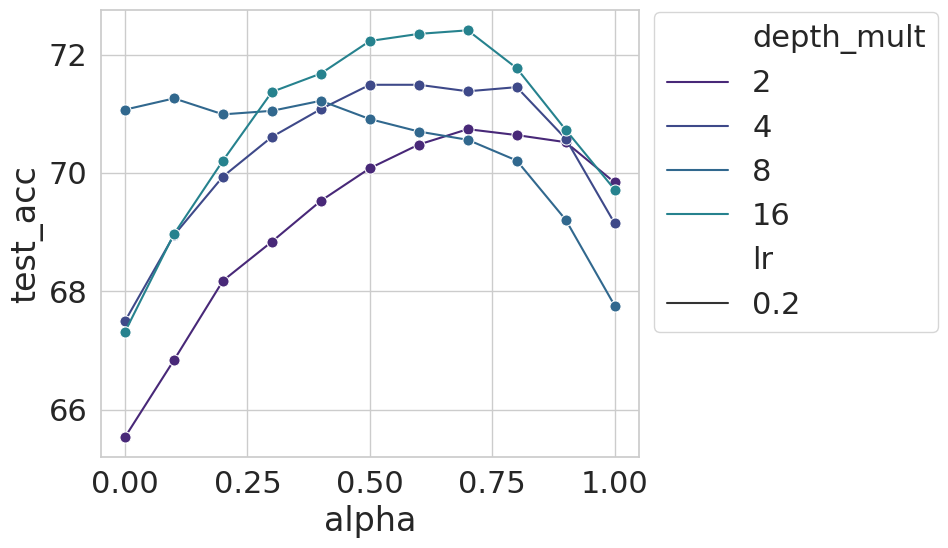

In [119]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
metric="test_acc"

df = df_runs[df_runs["width_mult"] == 4]
df = df[df["epoch"] == 9]
df = df[df["depth_mult"]>1]

#print(df)

ax = sns.lineplot(data=df, x='alpha', y=metric, hue="depth_mult", style='lr', markersize=8, palette=sns.color_palette("viridis", n_colors=8), errorbar=("ci", 80), marker="o")

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

# ax.set_yticks([1, 2, 4, 8])
# ax.set_yticklabels([r"$10^0$", r"$2\times 10^0$", r"$4\times 10^0$", r"$8\times 10^0$"])
plt.tight_layout()